<a href="https://colab.research.google.com/github/SufyAD/Agentic-AI/blob/main/Customer_Support_Agent.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
%%capture --no-stderr
%pip install -qU langgraph langchain-community langchain_google_genai langchain_core langgraph-checkpoint-sqlite

In [2]:
import getpass
import os


def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")


# _set_env("GEMINI_API_KEY")
# _set_env("LANGCHAIN_API_KEY")

### Populate database (Optional)
Populating our database with some dummydata to perform different operations such as `get_order_status`, `cancel_order`, `update_order`

In [3]:
!mkdir -p state_db && [ ! -f state_db/example.db ] && wget -P state_db https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db

--2025-01-11 07:02:03--  https://github.com/langchain-ai/langchain-academy/raw/main/module-2/state_db/example.db
Resolving github.com (github.com)... 140.82.112.4
Connecting to github.com (github.com)|140.82.112.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db [following]
--2025-01-11 07:02:03--  https://raw.githubusercontent.com/langchain-ai/langchain-academy/main/module-2/state_db/example.db
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.109.133, 185.199.111.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 110592 (108K) [application/octet-stream]
Saving to: ‘state_db/example.db’

example.db          100%[===================>] 108.00K  --.-KB/s    in 0.002s  

2025-01-11 07:02:03 (46.6 MB/s) - ‘s

In [4]:
# -------------------- Dummy Order ----------------------

from langchain.tools import tool
from typing_extensions import TypedDict
order_json: TypedDict = {
  "orders": [
      {
          "order_id": "12345",
          "status": "Processing",
          "expected_delivery": "2024-12-23",
          "items": [
              {"name": "Wireless Headphones", "category": "Audio", "price": 15000, "quantity": 1},
              {"name": "Smart Watch", "category": "Wearables", "price": 12000, "quantity": 1}
          ]
      },
      {
          "order_id": "67890",
          "status": "Shipped",
          "expected_delivery": "2024-12-25",
          "items": [
              {"name": "Gaming Mouse", "category": "Accessories", "price": 7000, "quantity": 1},
              {"name": "Mechanical Keyboard", "category": "Accessories", "price": 10000, "quantity": 1}
          ]
      },
      {
          "order_id": "11223",
          "status": "Delivered",
          "expected_delivery": "2024-12-20",
          "items": [
              {"name": "Portable Speaker", "category": "Audio", "price": 8000, "quantity": 1},
              {"name": "Smartphone Stand", "category": "Accessories", "price": 2000, "quantity": 2},
              {"name": "USB-C Hub", "category": "Connectivity", "price": 3000, "quantity": 1}
          ]
      }
  ]
}

In [5]:
#----------------------- Products in DB -----------------------
products = [
    {"name": "Wireless Headphones", "category": "Audio", "price": 15000, "stock": 10},
    {"name": "Smart Watch", "category": "Wearables", "price": 12000, "stock": 100},
    {"name": "Gaming Mouse", "category": "Accessories", "price": 5000, "stock": 50},
    {"name": "Mechanical Keyboard", "category": "Accessories", "price": 8000, "stock": 30},
    {"name": "Portable Power Bank", "category": "Energy", "price": 4000, "stock": 200},
    {"name": "Bluetooth Speaker", "category": "Audio", "price": 6000, "stock": 40},
    {"name": "Smart Glasses", "category": "Wearables", "price": 18000, "stock": 15},
    {"name": "Fitness Tracker", "category": "Wearables", "price": 7000, "stock": 80},
    {"name": "Drone with Camera", "category": "Drones", "price": 25000, "stock": 10},
    {"name": "4K Action Camera", "category": "Photography", "price": 15000, "stock": 25},
    {"name": "VR Headset", "category": "Gaming", "price": 22000, "stock": 20},
]

In [6]:
import sqlite3
db_path = "state_db/example.db"
conn = sqlite3.connect(db_path, check_same_thread=False) #conn is basically enables us to connect with our SQLite3 database otherwise we could not setup
cursor = conn.cursor()

In [7]:
cursor.execute(
    """
    CREATE TABLE IF NOT EXISTS products (
        name TEXT PRIMARY KEY,
        category TEXT,
        price INTEGER,
        stock INTEGER
    )
    """
)
for product in products:
    cursor.execute("""
    INSERT OR REPLACE INTO products (name, category, price, stock)
    VALUES (?, ?, ?, ?)
    """,(product["name"].lower(), product["category"], product["price"], product["stock"]))

    conn.commit()

In [8]:
cursor.execute("SELECT * FROM products")
rows = cursor.fetchall()
for row in rows:
    print(row)

('wireless headphones', 'Audio', 15000, 10)
('smart watch', 'Wearables', 12000, 100)
('gaming mouse', 'Accessories', 5000, 50)
('mechanical keyboard', 'Accessories', 8000, 30)
('portable power bank', 'Energy', 4000, 200)
('bluetooth speaker', 'Audio', 6000, 40)
('smart glasses', 'Wearables', 18000, 15)
('fitness tracker', 'Wearables', 7000, 80)
('drone with camera', 'Drones', 25000, 10)
('4k action camera', 'Photography', 15000, 25)
('vr headset', 'Gaming', 22000, 20)


In [9]:
from langgraph.checkpoint.sqlite import SqliteSaver
memory: SqliteSaver = SqliteSaver(conn)

In [10]:
# #Cleaing DB
cursor = conn.cursor()
# cursor.execute("DELETE FROM order_items")
# cursor.execute("DELETE FROM orders")

# # Optionally, you can reset the autoincrement if needed:
# # cursor.execute("DELETE FROM sqlite_sequence WHERE name='orders'")
# # cursor.execute("DELETE FROM sqlite_sequence WHERE name='order_items'")

# # Commit the changes and close the connection
# conn.commit()
# cursor.close()
# conn.close()

# print("Database cleaned and ready for new data.")

In [11]:
#creating tables if doesn't exist
cursor.execute("""
    CREATE TABLE IF NOT EXISTS orders (
        order_id TEXT PRIMARY KEY,
        status TEXT,
        expected_delivery TEXT
    )
    """)

cursor.execute("""
    CREATE TABLE IF NOT EXISTS order_items (
        order_id TEXT,
        name TEXT,
        category TEXT,
        price INTEGER,
        quantity INTEGER,
        FOREIGN KEY (order_id) REFERENCES orders(order_id)
    )
""")

# Populating data in the database
for order in order_json["orders"]:
    cursor.execute("""
    INSERT OR REPLACE INTO orders (order_id, status, expected_delivery)
    VALUES (?, ?, ?)
    """, (order["order_id"], order["status"], order["expected_delivery"]))

    # Now iterate over the items for each order and insert them into the order_items table
    for item in order["items"]:
        cursor.execute("""
        INSERT OR REPLACE INTO order_items (order_id, name, category, price, quantity)
        VALUES (?, ?, ?, ?, ?)
        """, (order["order_id"], item["name"].lower(), item["category"], item["price"], item["quantity"]))

conn.commit()

In [12]:
cursor.execute("""
  SELECT * FROM orders
""")
orders = cursor.fetchall()

cursor.execute("SELECT * FROM order_items")
order_items = cursor.fetchall()

In [13]:
# Print the data
print("Orders:")
for order in orders:
    print(order)

print("\nOrder Items:")
for item in order_items:
    print(item)

Orders:
('12345', 'Processing', '2024-12-23')
('67890', 'Shipped', '2024-12-25')
('11223', 'Delivered', '2024-12-20')

Order Items:
('12345', 'wireless headphones', 'Audio', 15000, 1)
('12345', 'smart watch', 'Wearables', 12000, 1)
('67890', 'gaming mouse', 'Accessories', 7000, 1)
('67890', 'mechanical keyboard', 'Accessories', 10000, 1)
('11223', 'portable speaker', 'Audio', 8000, 1)
('11223', 'smartphone stand', 'Accessories', 2000, 2)
('11223', 'usb-c hub', 'Connectivity', 3000, 1)


In [14]:
conn.commit()
cursor.close()

**Tools**
Next, define our assistant's `tools`

In [15]:
from langchain_google_genai import ChatGoogleGenerativeAI
from langchain_core.tools import tool

from IPython.display import Image, display

from langgraph.checkpoint.memory import MemorySaver
from langgraph.graph import MessagesState
from langgraph.graph import START, StateGraph
from langgraph.prebuilt import tools_condition, ToolNode
from langgraph.graph.state import CompiledStateGraph
from langchain_core.runnables import RunnableConfig
from langchain_core.messages import HumanMessage, SystemMessage
from langgraph.types import Command, interrupt

from typing_extensions import TypedDict

In [16]:
from google.colab import userdata
llm = ChatGoogleGenerativeAI(model="gemini-1.5-flash", api_key=userdata.get("GEMINI_API_KEY"))
# llm_with_tools = llm.bind_tools(tools) # to be added

In [17]:
llm.invoke("Hello")

AIMessage(content='Hello there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-377bb068-37b4-4066-857a-e9d007acde45-0', usage_metadata={'input_tokens': 2, 'output_tokens': 11, 'total_tokens': 13, 'input_token_details': {'cache_read': 0}})

In [18]:
from datetime import datetime, timedelta
from pydantic import BaseModel
from typing import Optional

class OrderState(TypedDict): #to handle order udpates
    order_id: str
    status: str
    expected_delivery: str

class State(MessagesState):
    orders_json: dict[str, list[OrderState]]

In [19]:
from time import time
from random import randint

def get_user_input() -> dict:
    while True:
        try:
            product_name = input("Enter the product name: ").lower()  # Ensuring lowercase for matching
            quantity = int(input("Enter the quantity: ").strip())

            if quantity <= 0:
                raise ValueError("Quantity must be a positive integer.")

            return {"product_name": product_name, "quantity": quantity}
        except ValueError as e:
            print(f"Error: {e}")


# Function to match product from the database
def match_product(db_path: str, product_name: str, quantity: int) -> dict:
    query = """
        SELECT name, category, price, stock
        FROM products
        WHERE name = ?
    """
    with sqlite3.connect(db_path) as conn:
        cursor = conn.cursor()
        cursor.execute(query, (product_name,))
        product = cursor.fetchone()

        if not product:
            raise ValueError(f"Product '{product_name}' not found in the database.")

        name, category, price, stock = product

        if quantity > stock:
            raise ValueError(f"Insufficient stock for '{name}'. Available: {stock}")

        return {
            "name": name,
            "category": category,
            "price": price,
            "quantity": quantity
        }

In [20]:
# Function to create an order
def create_order(db_path: str,order_id: str, matched_product: dict) -> dict:

    order_id = randint(100, 999)
    expected_delivery = "2025-01-05"  # Example date logic

    with sqlite3.connect(db_path) as conn:
        cursor = conn.cursor()

        # Insert into orders table
        query = """
        INSERT INTO orders (order_id, status, expected_delivery)
        VALUES (?, ?, ?)
        """
        cursor.execute(query, (order_id, "Processing", expected_delivery)) #for every new order we'll pass status as PROCESSING

        # Insert into order_items table
        query_item = """
        INSERT INTO order_items (order_id, name, category, price, quantity)
        VALUES (?, ?, ?, ?, ?)
        """
        cursor.execute(query_item, (
            order_id,
            matched_product["name"],
            matched_product["category"],
            matched_product["price"],
            matched_product["quantity"]
        ))

        # Update stock in products table
        query_stock_update = """
            UPDATE products SET stock = stock - ? WHERE name = ?
        """
        cursor.execute(query_stock_update, (matched_product["quantity"], matched_product["name"]))
        conn.commit()

    return {
        "order_id": order_id,
        "status": "Processing",
        "expected_delivery": expected_delivery,
        "items": [matched_product],
    }

In [21]:
@tool
def process_order(db_path: str) -> dict:
    """Handles product order creation, checking stock, and updating the database."""
    try:
        # Get user input for product and quantity
        user_input = get_user_input()

        # Match product from the database
        matched_product = match_product(db_path, user_input["product_name"], user_input["quantity"])

        # Create the order in the database
        order_details = create_order(db_path, matched_product)

        return order_details
    except ValueError as e:
        return {"error": str(e)}

In [22]:
@tool
def get_order_status(config: RunnableConfig) -> list[dict]:
    """
    Retrieves the status of an order based on its unique order ID.

    Args:
        config (RunnableConfig): Contains configuration for the order ID.

    Returns:
        List[Dict]: A list of dictionaries with order details, including:
            - `order_id` (str): The unique ID of the order.
            - `status` (str): The current status of the order (e.g., "Processing", "Shipped").
            - `expected_delivery` (str): The expected delivery date of the order (optional).
            - `items` (list of dict): The items related to the order.
    """
    # Get order_id from the config
    configuration = config.get("configurable", {})
    order_id = configuration.get("order_id", None)

    if not order_id:
        raise ValueError("order_id is required")

    # Connect to the SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Update SQL query to correctly join orders and order_items tables
    query = """
    SELECT
        orders.order_id,
        orders.status,
        orders.expected_delivery,
        order_items.name,
        order_items.category,
        order_items.price,
        order_items.quantity
    FROM
        orders
    JOIN
        order_items ON orders.order_id = order_items.order_id
    WHERE
        orders.order_id = ?
    """
    cursor.execute(query, (order_id,))
    rows = cursor.fetchall()

    # Create a list of dictionaries for the rows retrieved from the database
    column_names = [column[0] for column in cursor.description]
    results = [dict(zip(column_names, row)) for row in rows]

    cursor.close()
    conn.close()

    if not results:
        raise ValueError(f"Order with ID {order_id} not found")

    return results

### Cancelling an order
Right now it is kept simple that a common json of orders is passed through the functions and keep updating the content of this json, later we will replace this json with our database

In [23]:
import sqlite3
from langchain_core.runnables import RunnableConfig

@tool
def cancel_order(config: RunnableConfig) -> str:
    """
    Cancels the order based on its unique order ID.

    Args:
        config (RunnableConfig): The config containing the order ID.

    Returns:
        str: A message indicating whether the order was successfully canceled or not.
    """
    configuration = config.get("configurable", {})
    order_id = configuration.get("order_id", None)

    if not order_id:
        raise ValueError("order_id is required")

    # Connect to SQLite database
    conn = sqlite3.connect(db_path)
    cursor = conn.cursor()

    # Check if the order exists and get its status
    cursor.execute("""
        SELECT order_id, status FROM orders WHERE order_id = ?
    """, (order_id,))
    order = cursor.fetchone()

    if not order:
        cursor.close()
        conn.close()
        return f"Order with ID {order_id} not found."

    # If the order status is not "Delivered", we cancel it
    if order[1] != "Delivered":
        cursor.execute("""
            DELETE FROM orders WHERE order_id = ?
        """, (order_id,))
        cursor.execute("""
            DELETE FROM order_items WHERE order_id = ?
        """, (order_id,))
        conn.commit()
        cursor.close()
        conn.close()
        return f"Order {order_id} has been successfully canceled."

    cursor.close()
    conn.close()
    return f"Order {order_id} cannot be canceled as it has already been {order[1]}."


### Update an Order
Modifying the common json which will be replaced with our DB later


In [24]:
def update_order(db_path: str, order_id: str, matched_product: dict, config: RunnableConfig) -> dict:
    """
    Update the order details in the database.
    """
    # Extract configuration
    configuration = config.get("configurable", {})
    order_id = configuration.get("order_id")
    expected_delivery = configuration.get("expected_delivery", "7 days")

    # Validate `order_id`
    if not order_id:
        raise ValueError("Missing `order_id` in the configuration.")

    # Database operations
    with sqlite3.connect(db_path) as conn:
        cursor = conn.cursor()

        # Insert into orders table
        query = """
        INSERT INTO orders (order_id, status, expected_delivery)
        VALUES (?, ?, ?)
        """
        cursor.execute(query, (order_id, "Processing", expected_delivery))

        # Insert into order_items table
        query_item = """
        INSERT INTO order_items (order_id, name, category, price, quantity)
        VALUES (?, ?, ?, ?, ?)
        """
        cursor.execute(query_item, (
            order_id,
            matched_product["name"],
            matched_product["category"],
            matched_product["price"],
            matched_product["quantity"]
        ))

        # Update stock in products table
        query_stock_update = """
            UPDATE products SET stock = stock - ? WHERE name = ?
        """
        cursor.execute(query_stock_update, (matched_product["quantity"], matched_product["name"]))
        conn.commit()

    return {
        "order_id": order_id,
        "status": "Processing",
        "expected_delivery": expected_delivery,
        "items": [matched_product],
    }


In [25]:
@tool
def process_order(db_path: str) -> dict:
    """Handles product order creation, checking stock, and updating the database."""
    try:
        # Get user input for product and quantity
        user_input = get_user_input()

        # Match product from the database
        matched_product = match_product(db_path, user_input["product_name"], user_input["quantity"])

        # Create the order in the database
        order_details = update_order(db_path, matched_product)

        return order_details
    except ValueError as e:
        return {"error": str(e)}

In [26]:
from typing import Literal

def payment(input: dict, config: RunnableConfig) -> Literal["__end__", "assistant"]:
  """
  Handles the payment process for an order.
  """
  print("--- Payement Node executed ---")
  user_approval = interrupt("Are you sure you want to pay online?")
  if user_approval.lower() == "yes":
    return "assistant"
  return "__end__"

In [27]:
from langchain_core import tools
tools = [get_order_status, cancel_order, process_order]
llm_with_tools = llm.bind_tools(tools)

In [28]:
llm_with_tools.invoke("Hi")

AIMessage(content='Hi there! How can I help you today?', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'safety_ratings': []}, id='run-bd95437b-46f7-49d3-9c47-e5f5df4ed309-0', usage_metadata={'input_tokens': 275, 'output_tokens': 11, 'total_tokens': 286, 'input_token_details': {'cache_read': 0}})

In [29]:
from google.colab import userdata

def assistant(state: MessagesState):
  """
  Handles the processing of conversational messages using a language model with tools.
  """
  sys_msg = SystemMessage(content="""You are a helpful Order Management Assistant,
  you have to be always humble and positive with the user's query even if the customer loses his tone;
  Keep the situation under control
  Here are some important points to consider:
  - Be careful while cancelling an order and confirm it once before cancelling
  - Be careful while returning payment to any customer and confirm once
  """)

  return {"messages": [llm_with_tools.invoke([sys_msg] + state["messages"])]}

In [38]:
agent: StateGraph = StateGraph(MessagesState)

agent.add_node("assistant", assistant)
agent.add_node("tools", ToolNode(tools))

agent.add_edge(START, "assistant")
agent.add_conditional_edges(
    "assistant",
    tools_condition,
    "tools",
)

agent.add_edge("tools", "assistant")
agent.set_entry_point("assistant")

memory: MemorySaver = MemorySaver()
graph: CompiledStateGraph = agent.compile(checkpointer=memory)

### Adding Checkpointer right now - later we will replace this with out DB


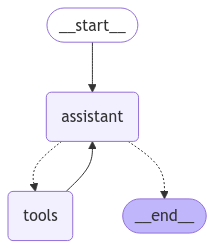

In [39]:
display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [42]:
# Input
initial_input = {"messages": "Yes please cancel it"}

# Thread
thread = {"configurable": {
    "thread_id": "3",
    "order_id": "12345"
    }}

# Run the graph until the first interruption
for event in graph.stream(initial_input, thread, stream_mode="values"):
    event['messages'][-1].pretty_print()

================================ Human Message =================================

Yes please cancel it
================================== Ai Message ==================================

Okay, I understand.  I'm now initiating the cancellation process for order 12345. Please wait a moment.
Tool Calls:
  cancel_order (3c14925b-0f22-4aec-866d-add8477e220e)
 Call ID: 3c14925b-0f22-4aec-866d-add8477e220e
  Args:
================================= Tool Message =================================
Name: cancel_order

Order 12345 has been successfully canceled.
================================== Ai Message ==================================

Order 12345 has been successfully canceled.  You'll receive a confirmation email shortly. Is there anything else I can help you with today?
